# Playing with the MovieLens dataset

To do this thing, first download the MovieLens 100K dataset here: http://grouplens.org/datasets/movielens/
Then, in the directory where you will store this `.ipynb` file, create a subdirectory `data` in which you will extract the file `ml-100k.zip`.

## Import some stuff

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = open('data/ml-100k/u.data')

## The data format

`u.data` has four fields: (1) user (2) item (3) rating (4) timestamp

What we'd like to do is first of all make some plots. A first plot we could do is the distribution of different ratings. To do that, we only need the rating field. Let's not keep too much in memory here, so that we could also work with bigger data sets if we wanted to. To create the first plot, we can walk through the file one by one, and create a dictionary of the values that `rating` takes as its keys, and the number of times a particular rating has been given as values. 

In [4]:
rating_counts = {}

In [5]:
for l in f:
    _, _, rating, _ = l.split('\t')
    if rating in rating_counts:
        rating_counts[rating] += 1
    else:
        rating_counts[rating] = 1
            

Now that we have walked through all the lines in the file, let's close it.

In [23]:
f.close()

In [18]:
ratings, counts = zip(*sorted(rating_counts.items()))

In [19]:
ratings, counts

(('1', '2', '3', '4', '5'), (6110, 11370, 27144, 34174, 21201))

## Doing a plot

In [20]:
%matplotlib inline

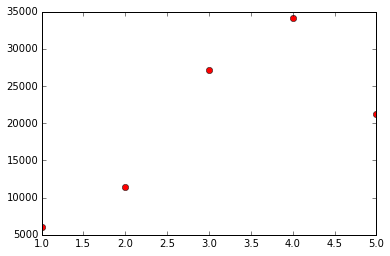

In [22]:
plt.plot(ratings, counts, 'ro')

So, the plot above does not yet look very pretty, but we can see already that people tend to be positive about movies, with the most common rating in this sample dataset being four stars.